In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
from pandas import DataFrame as dframe
import cvxpy as cv

In [2]:
def Dic(feat_l_tr,feat_r_tr): #入力の配列は2次元配列である必要がある
    feat_tr = np.concatenate([feat_l_tr, feat_r_tr],0)
    return feat_tr

In [3]:
def SRC(feat_tr_dic,feat_l_te,matrix_index):
    answer = np.zeros(feat_l_te.shape[1])
    SRC_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SRC_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SRC_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        x = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(cv.norm(x,1))
        constraints = [feat_l_te[:,i,np.newaxis] == feat_tr_dic@x]
        prob = cv.Problem(objective, constraints)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付ける
        SRC_Cla[:,i] = np.squeeze(x.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SRC_l_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SRC_r_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SRC_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SRC_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [4]:
def SRC_test(filename1,filename2,filename3,filename4,C1_K1,C2_K1,C1_K2,C2_K2,C1_K3,C2_K3):
    #対象被験者の特徴ベクトルをMATLABから入手
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #非対象被験者の特徴ベクトルをMATLABから入手
    feat_C1_K1 = np.loadtxt(C1_K1,delimiter=",")
    feat_C2_K1 = np.loadtxt(C2_K1,delimiter=",")
    feat_C1_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C2_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C1_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C2_K3 = np.loadtxt(C1_K3,delimiter=",")
    #Tは被験者の試行回数である
    feat_tr = Dic(feat_C1,feat_C2)
    #非対象被験者の特徴ベクトルも同様の処理を行う
    feat_tr_K1 = Dic(feat_C1_K1,feat_C2_K1)
    feat_tr_K2 = Dic(feat_C1_K2,feat_C2_K2)
    feat_tr_K3 = Dic(feat_C1_K3,feat_C2_K3)

    #それぞれの特徴ベクトルをつなげる
    feat_tr_dic_1 = Dic(feat_tr,feat_tr_K1)
    feat_tr_dic_2 = Dic(feat_tr_dic_1,feat_tr_K2)
    feat_tr_dic = Dic(feat_tr_dic_2,feat_tr_K3).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #まず、分類に用いるテストデータの特徴ベクトルを2次元に変換
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T

    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0],feat_C1_K1.shape[0],feat_C2_K1.shape[0],feat_C1_K2.shape[0],feat_C2_K2.shape[0],
                        feat_C1_K3.shape[0],feat_C2_K3.shape[0]])
    answer1 = SRC(feat_tr_dic,feat_l_te,matrix_index)
    answer2 = SRC(feat_tr_dic,feat_r_te,matrix_index)
    x1 = 0
    x2 = 0
    for i in range(answer1.shape[0]):
        if answer1[i] == 1:
            x1 = x1 + 1
        if answer2[i] == 2:
            x2 = x2 + 1
    temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
    temp1 = ((x1)/(answer1.shape[0]))*100
    temp2 = ((x2)/(answer2.shape[0]))*100
                    
    return temp,temp1,temp2

In [5]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20_K0.txt","feat_2a_250Hz_20/feat_right_A09T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A09T_20.txt","feat_2a_250Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[56.25       27.5        85.        ]
 [47.5         5.         90.        ]
 [57.5        52.5        62.5       ]
 [51.25       65.         37.5       ]
 [53.75       22.5        85.        ]
 [73.33333333 70.         76.66666667]]


In [6]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20_K0.txt","feat_2a_250Hz_20/feat_right_A09T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A09T_20.txt","feat_2a_250Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[ 48.75        15.          82.5       ]
 [ 50.           0.         100.        ]
 [ 65.          72.5         57.5       ]
 [ 48.75        95.           2.5       ]
 [ 55.          20.          90.        ]
 [ 65.          56.66666667  73.33333333]]


In [7]:
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20_K0.txt","feat_2a_250Hz_20/feat_right_A09T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A09T_20.txt","feat_2a_250Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[55.         22.5        87.5       ]
 [45.          7.5        82.5       ]
 [58.75       45.         72.5       ]
 [46.25       85.          7.5       ]
 [53.75       75.         32.5       ]
 [55.         83.33333333 26.66666667]]


In [8]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[53.33333333 21.66666667 85.        ]
 [47.5         4.16666667 90.83333333]
 [60.41666667 56.66666667 64.16666667]
 [48.75       81.66666667 15.83333333]
 [54.16666667 39.16666667 69.16666667]
 [64.44444444 70.         58.88888889]]


In [9]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A01T_20_K0.txt","feat_2a_125Hz_20/feat_right_A01T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A01T_20.txt","feat_2a_125Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A02T_20_K0.txt","feat_2a_125Hz_20/feat_right_A02T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A02T_20.txt","feat_2a_125Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A03T_20_K0.txt","feat_2a_125Hz_20/feat_right_A03T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A03T_20.txt","feat_2a_125Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A07T_20_K0.txt","feat_2a_125Hz_20/feat_right_A07T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A07T_20.txt","feat_2a_125Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A08T_20_K0.txt","feat_2a_125Hz_20/feat_right_A08T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A08T_20.txt","feat_2a_125Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A09T_20_K0.txt","feat_2a_125Hz_20/feat_right_A09T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A09T_20.txt","feat_2a_125Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A06T_30.txt","feat_2a_125Hz_30/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[47.5         7.5        87.5       ]
 [48.75       35.         62.5       ]
 [56.25       15.         97.5       ]
 [46.25       32.5        60.        ]
 [70.         70.         70.        ]
 [70.         56.66666667 83.33333333]]


In [10]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A01T_20_K0.txt","feat_2a_125Hz_20/feat_right_A01T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A01T_20.txt","feat_2a_125Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A02T_20_K0.txt","feat_2a_125Hz_20/feat_right_A02T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A02T_20.txt","feat_2a_125Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A03T_20_K0.txt","feat_2a_125Hz_20/feat_right_A03T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A03T_20.txt","feat_2a_125Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A07T_20_K0.txt","feat_2a_125Hz_20/feat_right_A07T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A07T_20.txt","feat_2a_125Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A08T_20_K0.txt","feat_2a_125Hz_20/feat_right_A08T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A08T_20.txt","feat_2a_125Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A09T_20_K0.txt","feat_2a_125Hz_20/feat_right_A09T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A09T_20.txt","feat_2a_125Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[47.5         7.5        87.5       ]
 [48.75       32.5        65.        ]
 [50.          5.         95.        ]
 [47.5        12.5        82.5       ]
 [48.75       80.         17.5       ]
 [63.33333333 83.33333333 43.33333333]]


In [11]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A01T_20_K0.txt","feat_2a_125Hz_20/feat_right_A01T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A01T_20.txt","feat_2a_125Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A02T_20_K0.txt","feat_2a_125Hz_20/feat_right_A02T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A02T_20.txt","feat_2a_125Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A03T_20_K0.txt","feat_2a_125Hz_20/feat_right_A03T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A03T_20.txt","feat_2a_125Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A07T_20_K0.txt","feat_2a_125Hz_20/feat_right_A07T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A07T_20.txt","feat_2a_125Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A08T_20_K0.txt","feat_2a_125Hz_20/feat_right_A08T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A08T_20.txt","feat_2a_125Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A09T_20_K0.txt","feat_2a_125Hz_20/feat_right_A09T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A09T_20.txt","feat_2a_125Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A06T_30.txt","feat_2a_125Hz_30_3/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[ 52.5         20.          85.        ]
 [ 52.5         55.          50.        ]
 [ 57.5         22.5         92.5       ]
 [ 53.75        42.5         65.        ]
 [ 56.25       100.          12.5       ]
 [ 61.66666667  96.66666667  26.66666667]]


In [12]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
print(p_average_125Hz)

[[49.16666667 11.66666667 86.66666667]
 [50.         40.83333333 59.16666667]
 [54.58333333 14.16666667 95.        ]
 [49.16666667 29.16666667 69.16666667]
 [58.33333333 83.33333333 33.33333333]
 [65.         78.88888889 51.11111111]]


In [13]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

54.768518518518526 54.375


[[49.16666667 50.         54.58333333 49.16666667 58.33333333 65.        ]
 [53.33333333 47.5        60.41666667 48.75       54.16666667 64.44444444]]


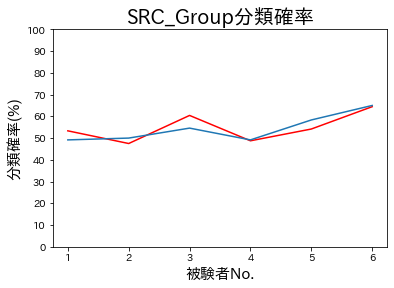

In [15]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_250Hz[:,0],y)
y = np.append(p_average_125Hz[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SRC_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("2a_SRC_group_probability_K3.pdf")
plt.show()